<a href="https://colab.research.google.com/github/ykato27/AutoEncorder/blob/main/vae_mnist_conv_lightning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional MNIST VAE

## Installation 

In [1]:
!mkdir figures
!mkdir scripts
%cd /content/scripts
!wget -q https://raw.githubusercontent.com/probml/pyprobml/master/scripts/pyprobml_utils.py
!wget -q https://raw.githubusercontent.com/probml/pyprobml/master/vae/standalone/lvm_plots_utils.py
!wget -q https://raw.githubusercontent.com/probml/pyprobml/master/vae/standalone/vae_conv_mnist.py
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/vae-mnist-conv-latent-dim-2.ckpt
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/vae-mnist-conv-latent-dim-20.ckpt

/content/scripts


In [2]:
%%capture
! pip install --quiet torchvision pytorch-lightning torch test-tube einops umap

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from einops import rearrange
from lvm_plots_utils import (
    get_grid_samples,
    get_imrange,
    get_random_samples,
    plot_grid_plot,
    plot_scatter_plot,
)
from pytorch_lightning import LightningModule, Trainer
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from vae_conv_mnist import ConvVAE

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
mnist_full = MNIST(
    ".",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Resize((32, 32))]),
)
dm = DataLoader(mnist_full, batch_size=250)
vis_data = DataLoader(mnist_full, batch_size=5000)
batch = next(iter(vis_data))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## VAE

In [6]:
m = ConvVAE(
    (1, 28, 28),
    encoder_conv_filters=[28, 64, 64],
    decoder_conv_t_filters=[64, 28, 1],
    latent_dim=20,
    kl_coeff=5,
)
m2 = ConvVAE(
    (1, 28, 28),
    encoder_conv_filters=[28, 64, 64],
    decoder_conv_t_filters=[64, 28, 1],
    latent_dim=2,
    kl_coeff=5,
)

In [7]:
m.load_state_dict(torch.load("vae-mnist-conv-latent-dim-20.ckpt"))
m2.load_state_dict(torch.load("vae-mnist-conv-latent-dim-2.ckpt"))

<All keys matched successfully>

In [8]:
m.eval()
m.to(device)
m2.eval()
m2.to(device)

ConvVAE(
  (vae): ConvVAEModule(
    (enc_convs): ModuleList(
      (0): Conv2d(1, 28, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): Conv2d(28, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): LeakyReLU(negative_slope=0.01)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): LeakyReLU(negative_slope=0.01)
    )
    (mu_linear): Linear(in_features=1024, out_features=2, bias=True)
    (log_var_linear): Linear(in_features=1024, out_features=2, bias=True)
    (decoder_linear): Linear(in_features=2, out_features=1024, bias=True)
    (dec_t_convs): ModuleList(
      (0): UpsamplingNearest2d(scale_factor=2.0, mode=nearest)
      (1): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): LeakyReLU(negative_slope=0.01)
      (3): UpsamplingNearest2d(scale_factor=2.0, mode=nearest)
      (4): ConvTranspose2d(64, 28, kernel_size=(3, 3), stride=(1, 1), padd

## Reconstruction

### ConvVAE with latent dim 20

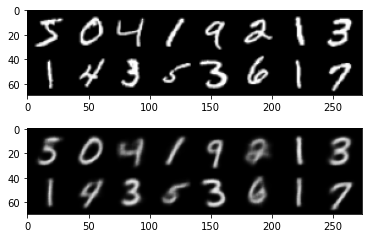

In [9]:
imgs, _ = batch
imgs = imgs[:16]

fig, axs = plt.subplots(2, 1)
axs[0].imshow(rearrange(make_grid(imgs), "c h w -> h w c"))
imgs = imgs.to(device=device)
axs[1].imshow(rearrange(make_grid(m.vae(imgs)[0].cpu()), "c h w -> h w c"))
plt.savefig("../figures/vae_mnist_conv_20d_rec.pdf")
plt.show()

In [10]:
!ls

lvm_plots_utils.py  vae_conv_mnist.py
MNIST		    vae-mnist-conv-latent-dim-20.ckpt
__pycache__	    vae-mnist-conv-latent-dim-2.ckpt
pyprobml_utils.py


### ConvVAE with latent dim 2

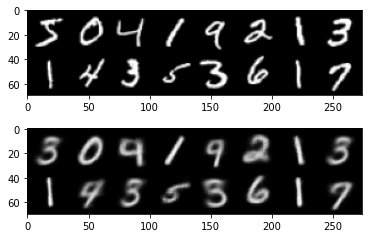

In [11]:
imgs, _ = batch
imgs = imgs[:16]

fig, axs = plt.subplots(2, 1)
axs[0].imshow(rearrange(make_grid(imgs), "c h w -> h w c"))
imgs = imgs.to(device=device)
axs[1].imshow(rearrange(make_grid(m2.vae(imgs)[0].cpu()), "c h w -> h w c"))
plt.savefig("../figures/vae_mnist_conv_2d_rec.pdf")
plt.show()

## Sampling

### Random samples form truncated unit normal distribution

We sample $z \sim TN(0,1)$ form a truncated normal distribution with a threshold = 5

#### ConvVAE with latent dim 20

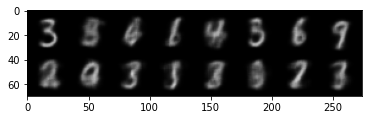

In [12]:
def decoder(z):
    return m.vae.decode(z)


plt.figure()
# imgs= get_random_samples(decoder, truncation_threshold=5)
imgs = get_random_samples(
    decoder, truncation_threshold=5, num_images_per_row=8, num_images=16
)
plt.imshow(imgs)
plt.savefig("../figures/vae_mnist_conv_20d_samples.pdf")

#### ConvVAE with latent dim 2

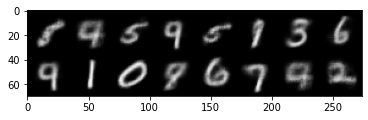

In [13]:
def decoder(z):
    return m2.vae.decode(z)


plt.figure()
imgs = get_random_samples(
    decoder, truncation_threshold=5, num_images_per_row=8, num_images=16
)
plt.imshow(imgs)
plt.savefig("../figures/vae_mnist_conv_2d_samples.pdf")

### Grid Sampling

We let $z = [z1, z2, 0, \ldots, 0]$ and vary $z1, z2$ on a grid

#### ConvVAE with latent dim 20

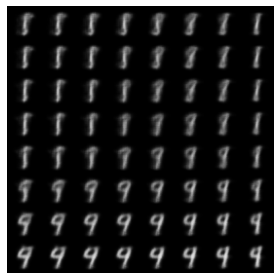

In [14]:
def decoder(z):
    return m.vae.decode(z)[0]


# plt.figure(figsize=(10,10))
plt.figure()
# plt.imshow(rearrange(make_grid(get_grid_samples(decoder, 20), 10), " c h w -> h w c").cpu())
nimgs = 8
nlatents = 20
plt.imshow(
    rearrange(
        make_grid(get_grid_samples(decoder, nlatents, nimgs), nimgs), " c h w -> h w c"
    ).cpu()
)
plt.axis("off")
plt.tight_layout()
plt.savefig("../figures/vae_mnist_conv_20d_grid.pdf")

#### ConvVAE with latent dim 2

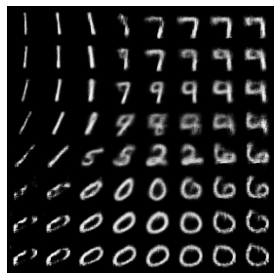

In [15]:
def decoder(z):
    return m2.vae.decode(z)[0]


plt.figure()
nimgs = 8
nlatents = 2
plt.imshow(
    rearrange(
        make_grid(get_grid_samples(decoder, nlatents, nimgs), nimgs), " c h w -> h w c"
    ).cpu()
)
plt.axis("off")
plt.tight_layout()
plt.savefig("../figures/vae_mnist_conv_2d_grid.pdf")

## 2D Color embedding of latent space

### ConvVAE with latent dim 20

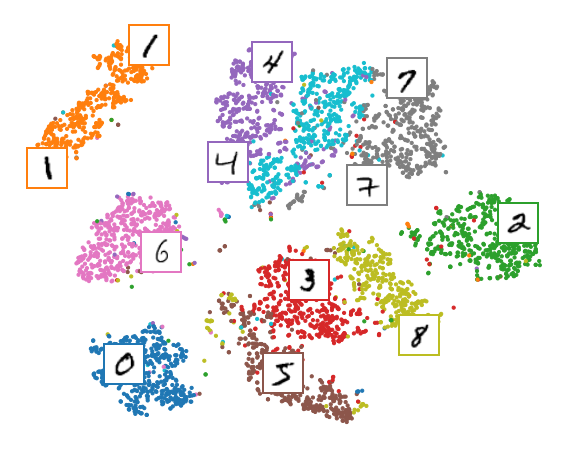

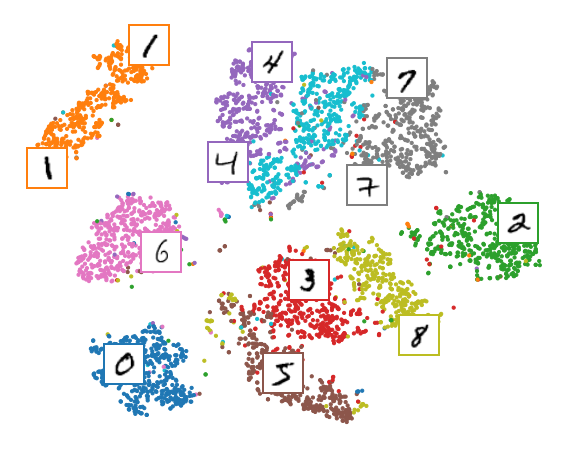

In [16]:
def encoder(img):
    return m.vae.encode(img)[0]


def decoder(z):
    z = z.to(device)
    return rearrange(m.vae.decode(z), "b c h w -> b (c h) w")


plot_scatter_plot(batch, encoder)

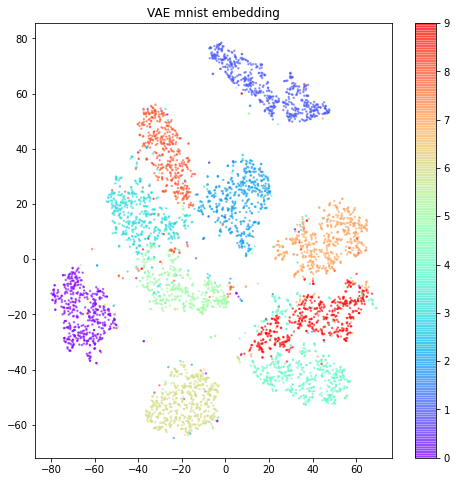

In [17]:
def encoder(img):
    return m.vae.encode(img)[0]


def decoder(z):
    z = z.to(device)
    return rearrange(m.vae.decode(z), "b c h w -> b (c h) w")


fig = plot_grid_plot(batch, encoder)
fig.savefig("../figures/vae_mnist_conv_20d_embed.pdf")
plt.show()

### ConvVAE with latent dim 2

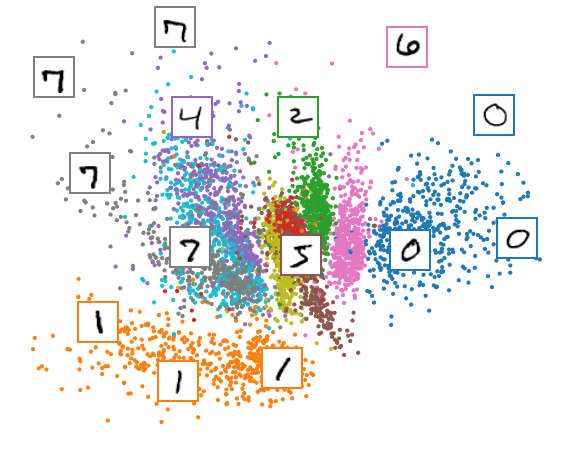

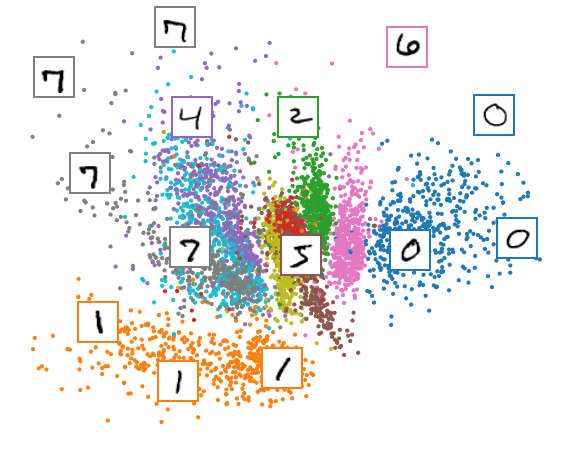

In [18]:
def encoder(img):
    return m2.vae.encode(img)[0].cpu().detach().numpy()


def decoder(z):
    z = z.to(device)
    return rearrange(m2.vae.decode(z), "b c h w -> b (c h) w")


plot_scatter_plot(batch, encoder)

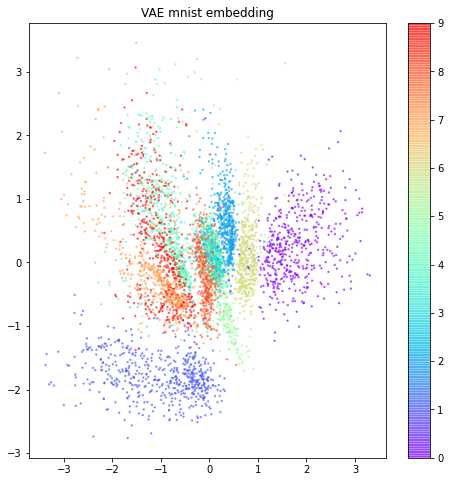

In [19]:
fig = plot_grid_plot(batch, encoder)
fig.savefig("../figures/vae_mnist_conv_2d_embed.pdf")

## Interpolation 

### Spherical Interpolation

#### ConvVAE with latent dim 20

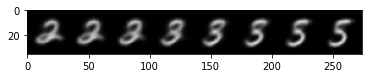

In [20]:
def decoder(z):
    z = z.to(device)
    return rearrange(m.vae.decode(z), "b c h w -> b (c h) w")


def encoder(img):
    return m.vae.encode(img)[0].cpu().detach()


imgs, _ = batch
imgs = imgs.to(device)
z_imgs = encoder(imgs)
# end, start = z_imgs[1], z_imgs[3]
end, start = z_imgs[0], z_imgs[5]

plt.figure()
arr = get_imrange(decoder, start, end, interpolation="spherical")
plt.imshow(arr)
plt.savefig("../figures/vae_mnist_conv_20d_spherical.pdf")

#### ConvVAE with latent dim 2

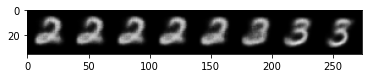

In [21]:
def decoder(z):
    z = z.to(device)
    return rearrange(m2.vae.decode(z), "b c h w -> b (c h) w")


def encoder(img):
    return m2.vae.encode(img)[0].cpu().detach()


imgs, _ = batch
imgs = imgs.to(device)
z_imgs = encoder(imgs)
end, start = z_imgs[0], z_imgs[5]

plt.figure()
arr = get_imrange(decoder, start, end, interpolation="spherical")
plt.imshow(arr)
plt.savefig("../figures/vae_mnist_conv_2d_spherical.pdf")

### Linear Interpolation

#### ConvVAE with latent dim 20

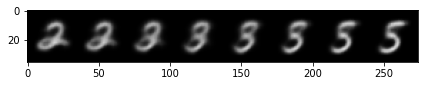

In [22]:
def decoder(z):
    z = z.to(device)
    return rearrange(m.vae.decode(z), "b c h w -> b (c h) w")


def encoder(img):
    return m.vae.encode(img)[0].cpu().detach()


imgs, _ = batch
imgs = imgs.to(device)
z_imgs = encoder(imgs)
end, start = z_imgs[0], z_imgs[5]

plt.figure()
arr = get_imrange(decoder, start, end, interpolation="linear")
plt.imshow(arr)
plt.tight_layout()
plt.savefig("../figures/vae_mnist_conv_20d_linear.pdf")

#### ConvVAE with latent dim 2

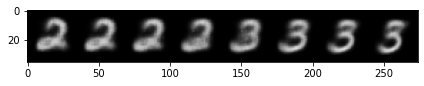

In [23]:
def decoder(z):
    z = z.to(device)
    return rearrange(m2.vae.decode(z), "b c h w -> b (c h) w")


def encoder(img):
    return m2.vae.encode(img)[0].cpu().detach()


imgs, _ = batch
imgs = imgs.to(device)
z_imgs = encoder(imgs)
# end, start = z_imgs[1], z_imgs[3]
end, start = z_imgs[0], z_imgs[5]

plt.figure()
arr = get_imrange(decoder, start, end, interpolation="linear")
plt.imshow(arr)
plt.tight_layout()
plt.savefig("../figures/vae_mnist_conv_2d_linear.pdf")